# Regression with an Insurance Dataset

## Import Libraries

In [1]:
pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.2 which is incompatible.
Note: you may n

In [2]:
pip install optuna-integration[sklearn]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn
sklearn.__version__

'1.6.0'

In [4]:
# Importing Libraries
import numpy as np 
import pandas as pd
# Data Visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
# Ignore warnings
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")
# Correlation Matrix
import phik
from phik.report import plot_correlation_matrix

import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import optuna

## Load Datasets

In [5]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

## Train Data Overview

In [6]:
train_data.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [8]:
# Convert objects to datetime
train_data['Policy Start Date'] = pd.to_datetime(train_data['Policy Start Date'])

In [9]:
train_data.isna().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

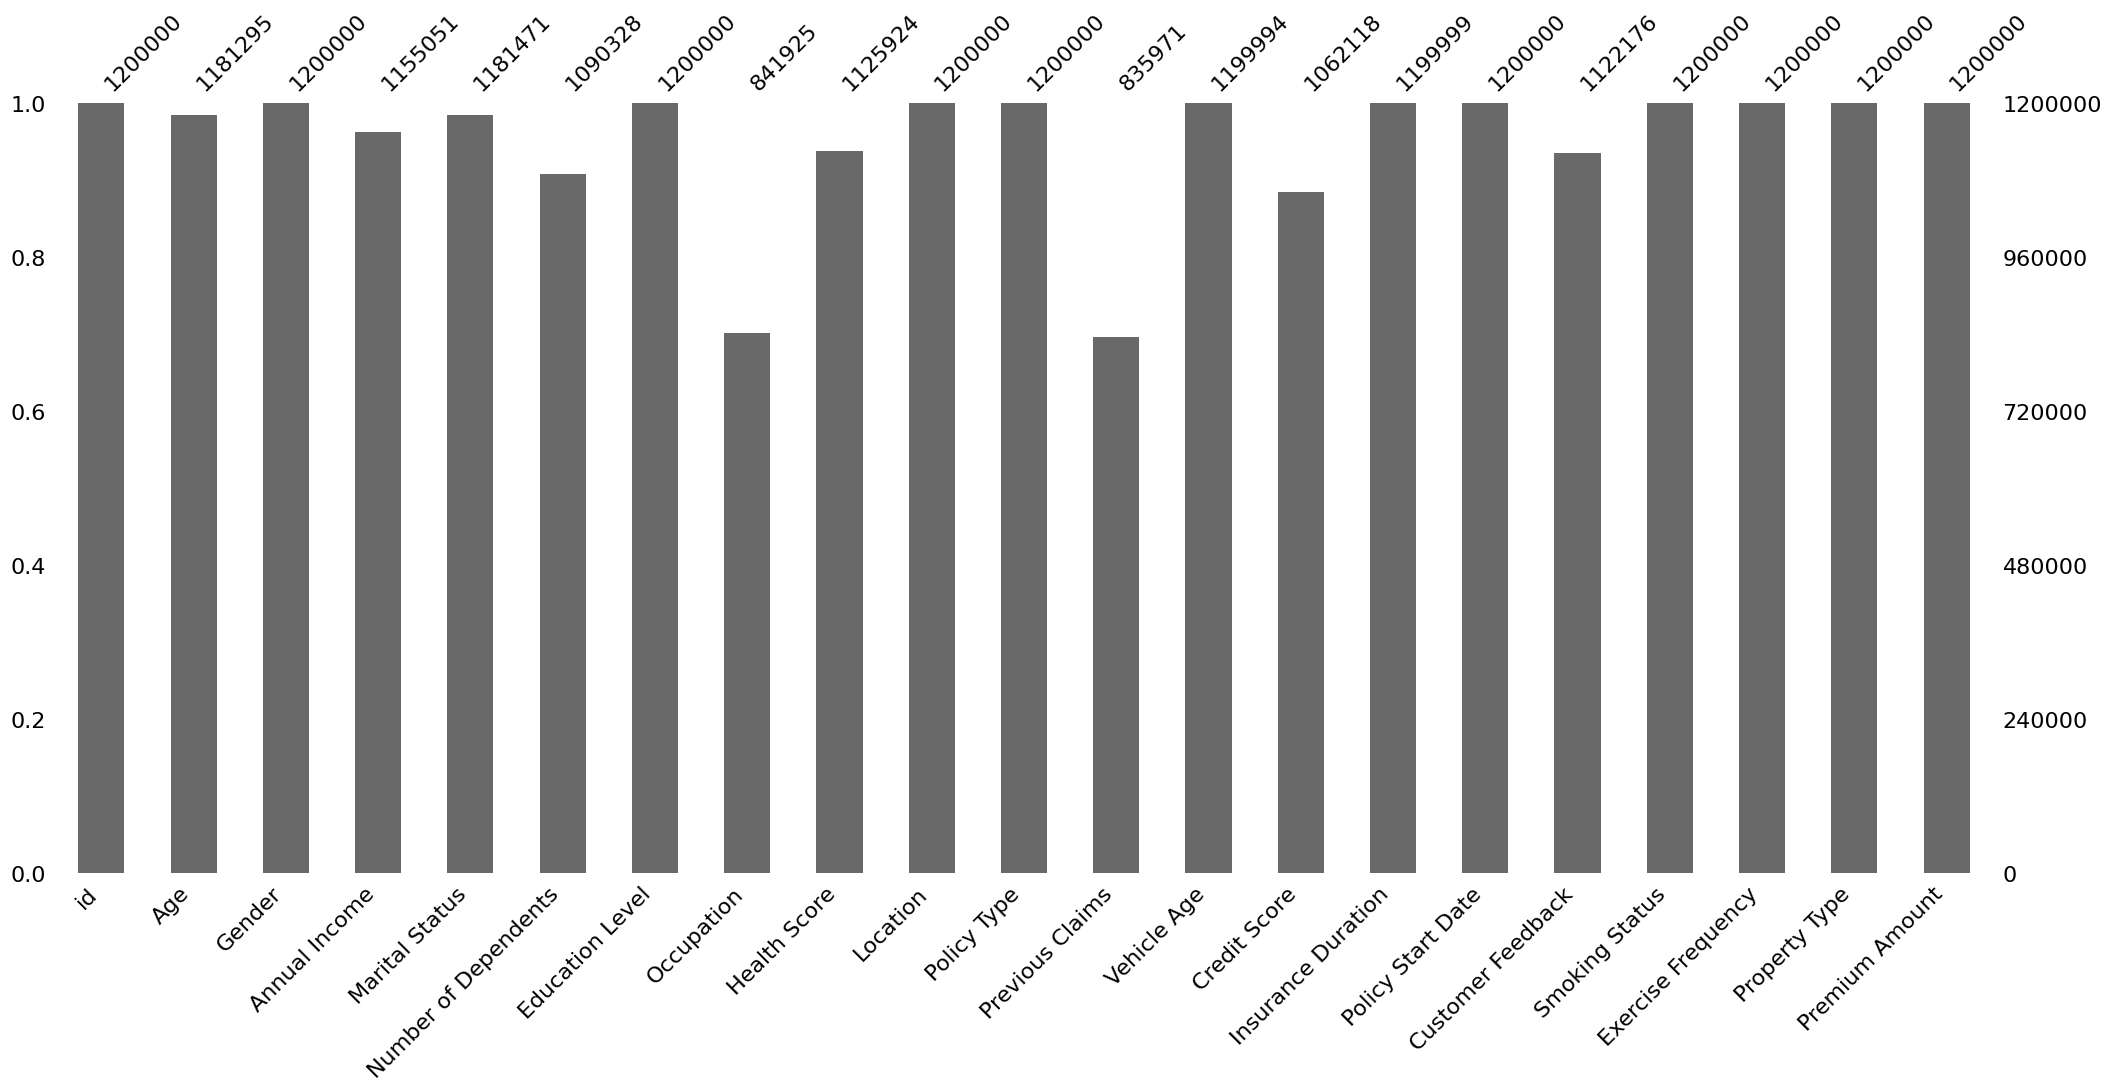

In [10]:
msno.bar(train_data)
plt.show()

In [11]:
train_data.duplicated().sum()

0

In [12]:
for col in train_data.select_dtypes(include=['object']).columns:
    print(train_data[col].unique())

['Female' 'Male']
['Married' 'Divorced' 'Single' nan]
["Bachelor's" "Master's" 'High School' 'PhD']
['Self-Employed' nan 'Employed' 'Unemployed']
['Urban' 'Rural' 'Suburban']
['Premium' 'Comprehensive' 'Basic']
['Poor' 'Average' 'Good' nan]
['No' 'Yes']
['Weekly' 'Monthly' 'Daily' 'Rarely']
['House' 'Apartment' 'Condo']


In [13]:
# Print top 10 unique value counts for each categorical column
for column in train_data.select_dtypes(include=['object']).columns:
    print(f"\nTop value counts in '{column}':\n{train_data[column].value_counts()}")


Top value counts in 'Gender':
Gender
Male      602571
Female    597429
Name: count, dtype: int64

Top value counts in 'Marital Status':
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Top value counts in 'Education Level':
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Top value counts in 'Occupation':
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Top value counts in 'Location':
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Top value counts in 'Policy Type':
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Top value counts in 'Customer Feedback':
Customer Feedback
Average    377905
Poor       375518
Good       368753
Name: count, dtype: int64

Top value counts in 'Smoking Status':
S

## Visualization of Numerical Features

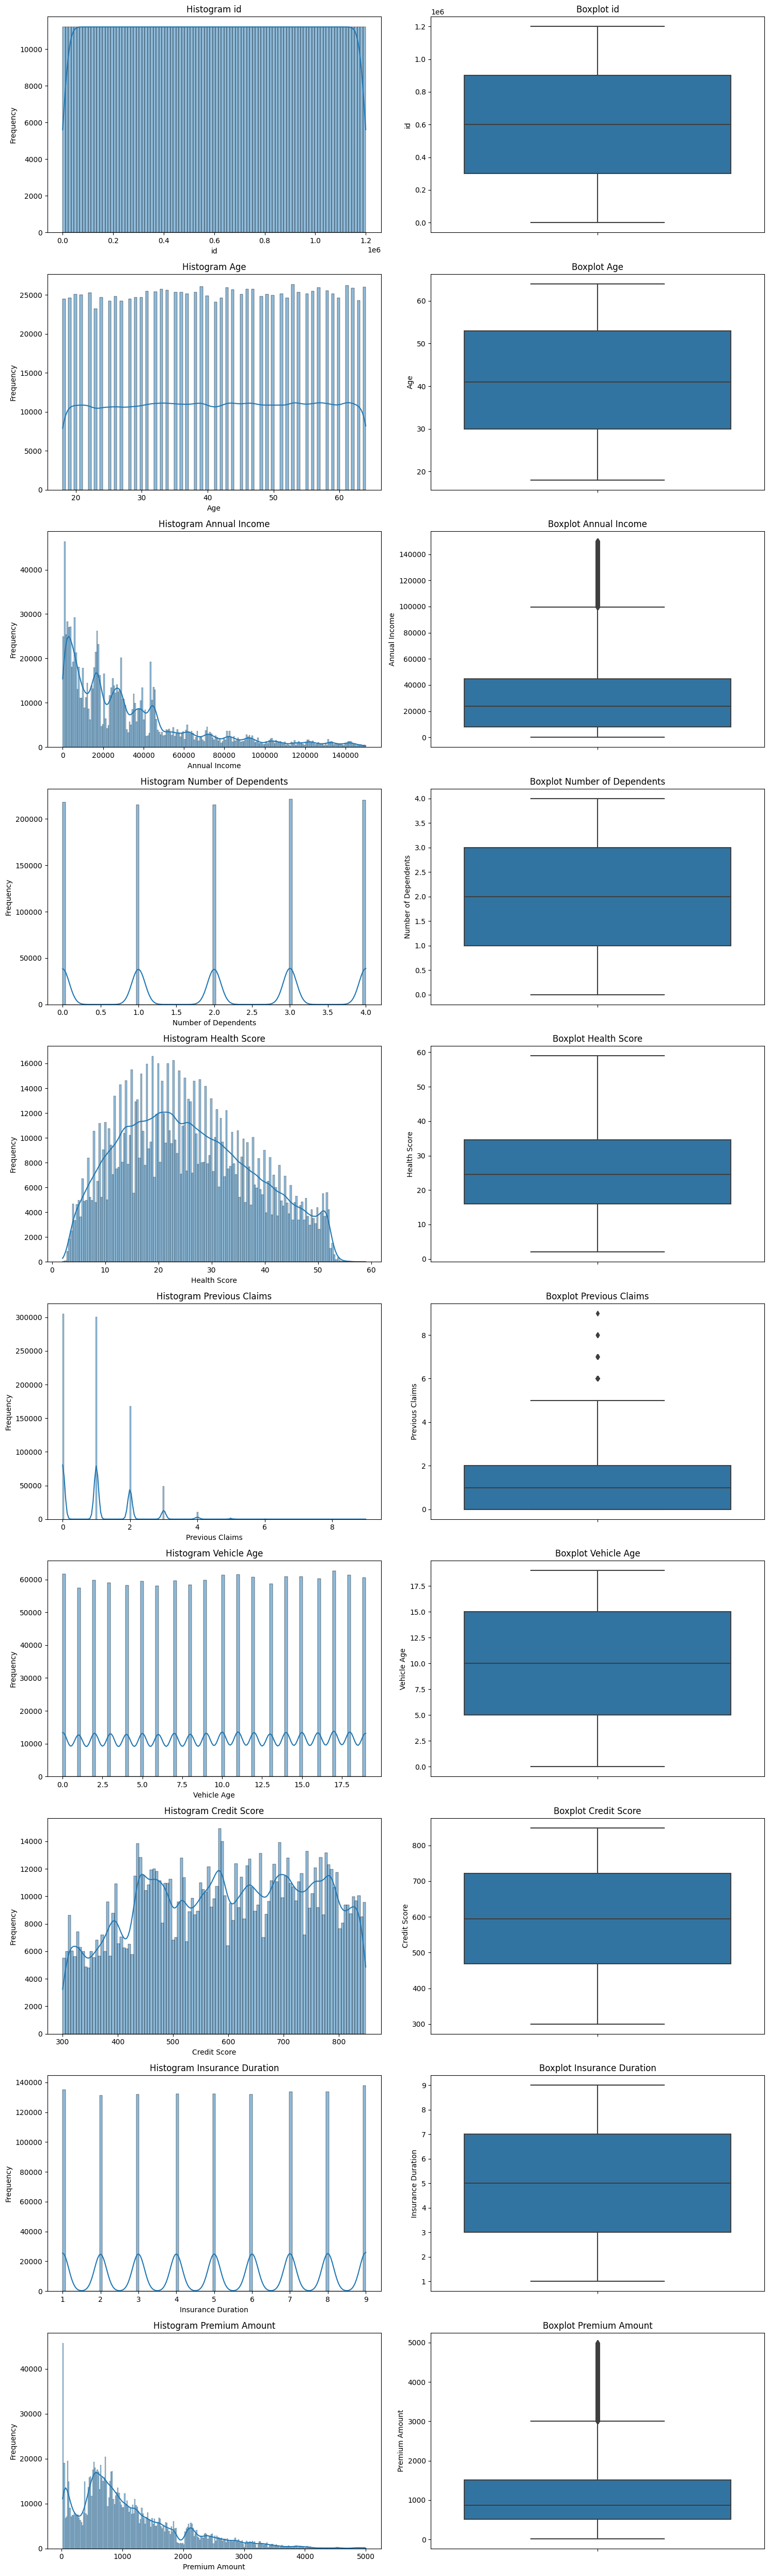

In [14]:
def plot_numerical_features(df):
    numerical_cols = df.select_dtypes(include=['number']).columns

    num_cols = len(numerical_cols)
    fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(15, 5*num_cols)) 

    for i, col in enumerate(numerical_cols):
        # Histogram
        sns.histplot(data=df, x=col, kde=True, ax=axes[i, 0]) 
        axes[i, 0].set_title(f'Histogram {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(y=df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot {col}')
        axes[i, 1].set_ylabel(col)

    plt.tight_layout() 
    plt.show()


plot_numerical_features(train_data)

## Visualization of Categorical Features

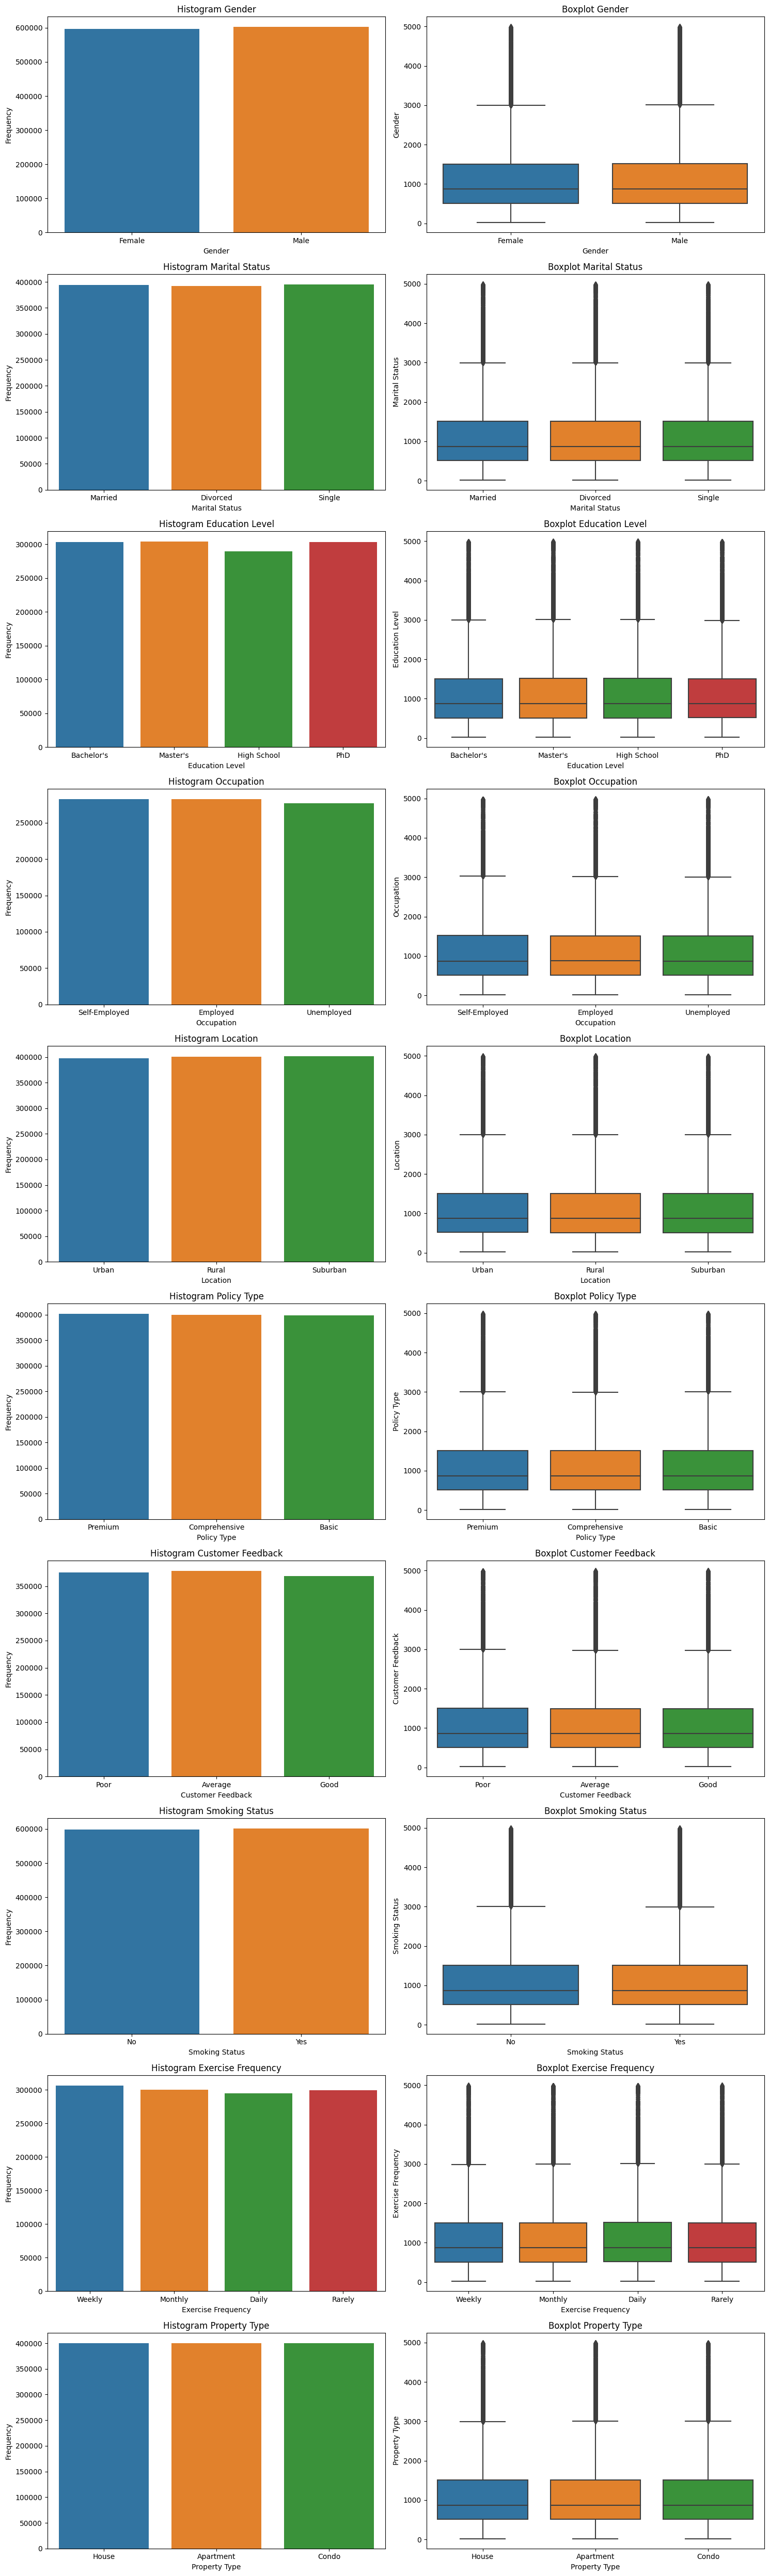

In [15]:
def plot_categorical_features(df, target_column):
    categorical_cols = df.select_dtypes(include=['object']).columns

    cat_cols = len(categorical_cols)
    fig, axes = plt.subplots(nrows=cat_cols, ncols=2, figsize=(15, 5*cat_cols)) 

    for i, col in enumerate(categorical_cols):
        # Histogram
        sns.countplot(data=df, x=col, ax=axes[i, 0]) 
        axes[i, 0].set_title(f'Histogram {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(x=df[col], y=df[target_column], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot {col}')
        axes[i, 1].set_ylabel(col)

    plt.tight_layout() 
    plt.show()


plot_categorical_features(train_data, target_column='Premium Amount')

## Correlation Heatmap of Numerical Features

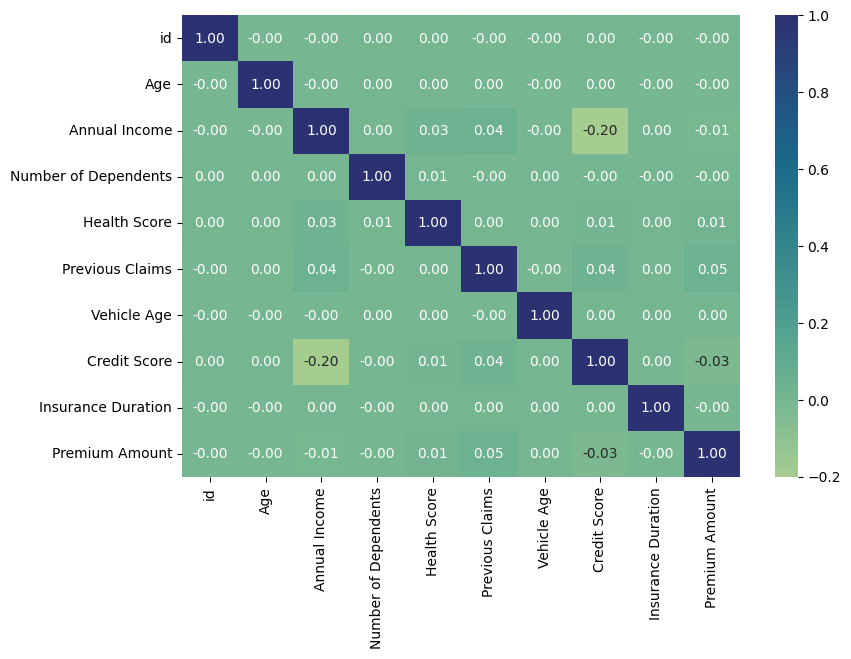

In [16]:
plt.figure(figsize = (9, 6))
sns.heatmap(train_data[train_data.select_dtypes(include=['number']).columns].corr(), annot=True, fmt='.2f', cmap='crest')
plt.show()

In [17]:
num_col_names = ['Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration']

cat_col_names = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Property Type']

target_column = 'Premium Amount'

## Split Data: Train and Validation Datasets

In [18]:
RANDOM_STATE = 42
TEST_SIZE = 0.25


X = train_data[num_col_names + cat_col_names]
y = train_data[target_column]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

print(X_train.shape, X_val.shape)

(900000, 18) (300000, 18)


## Build Pipeline

In [19]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_col_names),
    ('num', num_pipeline, num_col_names)
])

In [20]:
X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_val_preprocessed = data_preprocessor.transform(X_val)
X_test = test_data[num_col_names + cat_col_names]
X_test_preprocessed = data_preprocessor.transform(X_test)

In [21]:
# Load the train and validation data into the LightGBM dataset object
lgb_train = lgb.Dataset(X_train_preprocessed, y_train)
lgb_eval = lgb.Dataset(X_val_preprocessed, y_val, reference=lgb_train)

In [22]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 20),  # -1 означает отсутствие ограничения
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_bin': trial.suggest_int('max_bin', 100, 500)
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_preprocessed, y_train)
    predictions = model.predict(X_val_preprocessed)
    rmse = root_mean_squared_error(y_val, predictions)
    return rmse

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-12-14 15:34:24,784] A new study created in memory with name: no-name-db745cdc-cd18-4a45-9321-0dfc3d3e8c0d
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/tmp/ipykernel_17/4246512117.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.su

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9078297666487372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078297666487372
[LightGBM] [Warning] lambda_l2 is set=2.437855616072549e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.437855616072549e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.032340236305034166, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.032340236305034166
[LightGBM] [Warning] lambda_l1 is set=0.03597589238362609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03597589238362609
[LightGBM] [Warning] bagging_fraction is set=0.56867192404276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.56867192404276
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] m

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.032340236305034166, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.032340236305034166
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9078297666487372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078297666487372
[LightGBM] [Warning] lambda_l2 is set=2.437855616072549e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.437855616072549e-06
[LightGBM] [Warning] lambda_l1 is set=0.03597589238362609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03597589238362609
[LightGBM] [Warning] bagging_fraction is set=0.56867192404276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.56867192404276
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2024-12-14 15:34:50,000] Trial 0 finished with value: 952.7505987888636 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.009736574214882445, 'num_leaves': 52, 'max_depth': 8, 'min_data_in_leaf': 100, 'min_sum_hessian_in_leaf': 0.032340236305034166, 'feature_fraction': 0.9078297666487372, 'bagging_fraction': 0.56867192404276, 'bagging_freq': 9, 'lambda_l1': 0.03597589238362609, 'lambda_l2': 2.437855616072549e-06, 'max_bin': 455}. Best is trial 0 with value: 952.7505987888636.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5336227050236371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336227050236371
[LightGBM] [Warning] lambda_l2 is set=6.277555476659144e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277555476659144e-08
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.028734565040871116, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.028734565040871116
[LightGBM] [Warning] lambda_l1 is set=7.342635226412584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.342635226412584
[LightGBM] [Warning] bagging_fraction is set=0.9514873231917462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9514873231917462
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.028734565040871116, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.028734565040871116
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.5336227050236371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336227050236371
[LightGBM] [Warning] lambda_l2 is set=6.277555476659144e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.277555476659144e-08
[LightGBM] [Warning] lambda_l1 is set=7.342635226412584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.342635226412584
[LightGBM] [Warning] bagging_fraction is set=0.9514873231917462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9514873231917462
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2024-12-14 15:35:16,185] Trial 1 finished with value: 926.8332298204556 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.021456355396849203, 'num_leaves': 124, 'max_depth': 3, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 0.028734565040871116, 'feature_fraction': 0.5336227050236371, 'bagging_fraction': 0.9514873231917462, 'bagging_freq': 9, 'lambda_l1': 7.342635226412584, 'lambda_l2': 6.277555476659144e-08, 'max_bin': 487}. Best is trial 1 with value: 926.8332298204556.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.5208856966501376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208856966501376
[LightGBM] [Warning] lambda_l2 is set=2.259901404877639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259901404877639
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.4584357572039265, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.4584357572039265
[LightGBM] [Warning] lambda_l1 is set=1.0616240295326505e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0616240295326505e-05
[LightGBM] [Warning] bagging_fraction is set=0.5966373252209198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5966373252209198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_d

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.4584357572039265, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.4584357572039265
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.5208856966501376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208856966501376
[LightGBM] [Warning] lambda_l2 is set=2.259901404877639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259901404877639
[LightGBM] [Warning] lambda_l1 is set=1.0616240295326505e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0616240295326505e-05
[LightGBM] [Warning] bagging_fraction is set=0.5966373252209198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5966373252209198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-12-14 15:35:24,202] Trial 2 finished with value: 861.782676091784 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.024439238671103734, 'num_leaves': 230, 'max_depth': 2, 'min_data_in_leaf': 94, 'min_sum_hessian_in_leaf': 0.4584357572039265, 'feature_fraction': 0.5208856966501376, 'bagging_fraction': 0.5966373252209198, 'bagging_freq': 1, 'lambda_l1': 1.0616240295326505e-05, 'lambda_l2': 2.259901404877639, 'max_bin': 156}. Best is trial 2 with value: 861.782676091784.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.8995266969318514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995266969318514
[LightGBM] [Warning] lambda_l2 is set=0.03422862096611028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03422862096611028
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.2503570373865238, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.2503570373865238
[LightGBM] [Warning] lambda_l1 is set=0.0018206508990394916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018206508990394916
[LightGBM] [Warning] bagging_fraction is set=0.8678096458560618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8678096458560618
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.2503570373865238, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.2503570373865238
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.8995266969318514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995266969318514
[LightGBM] [Warning] lambda_l2 is set=0.03422862096611028, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03422862096611028
[LightGBM] [Warning] lambda_l1 is set=0.0018206508990394916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018206508990394916
[LightGBM] [Warning] bagging_fraction is set=0.8678096458560618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8678096458560618
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-12-14 15:35:43,284] Trial 3 finished with value: 850.9884880737683 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.012231684544095473, 'num_leaves': 40, 'max_depth': 10, 'min_data_in_leaf': 75, 'min_sum_hessian_in_leaf': 0.2503570373865238, 'feature_fraction': 0.8995266969318514, 'bagging_fraction': 0.8678096458560618, 'bagging_freq': 5, 'lambda_l1': 0.0018206508990394916, 'lambda_l2': 0.03422862096611028, 'max_bin': 314}. Best is trial 3 with value: 850.9884880737683.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.5553387949064128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5553387949064128
[LightGBM] [Warning] lambda_l2 is set=0.0156526597477304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0156526597477304
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.06802223263747721, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.06802223263747721
[LightGBM] [Warning] lambda_l1 is set=0.299470432682068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.299470432682068
[LightGBM] [Warning] bagging_fraction is set=0.9833181994177258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9833181994177258
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.06802223263747721, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.06802223263747721
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.5553387949064128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5553387949064128
[LightGBM] [Warning] lambda_l2 is set=0.0156526597477304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0156526597477304
[LightGBM] [Warning] lambda_l1 is set=0.299470432682068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.299470432682068
[LightGBM] [Warning] bagging_fraction is set=0.9833181994177258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9833181994177258
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-12-14 15:36:51,929] Trial 4 finished with value: 973.847548053522 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.005194648390152434, 'num_leaves': 218, 'max_depth': 17, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.06802223263747721, 'feature_fraction': 0.5553387949064128, 'bagging_fraction': 0.9833181994177258, 'bagging_freq': 2, 'lambda_l1': 0.299470432682068, 'lambda_l2': 0.0156526597477304, 'max_bin': 285}. Best is trial 3 with value: 850.9884880737683.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.9712755094268402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9712755094268402
[LightGBM] [Warning] lambda_l2 is set=0.00047867981681082306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047867981681082306
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.007565361148361053, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.007565361148361053
[LightGBM] [Warning] lambda_l1 is set=5.301860194091793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.301860194091793
[LightGBM] [Warning] bagging_fraction is set=0.6616188615407864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6616188615407864
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] m

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.007565361148361053, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.007565361148361053
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.9712755094268402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9712755094268402
[LightGBM] [Warning] lambda_l2 is set=0.00047867981681082306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047867981681082306
[LightGBM] [Warning] lambda_l1 is set=5.301860194091793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.301860194091793
[LightGBM] [Warning] bagging_fraction is set=0.6616188615407864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6616188615407864
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2024-12-14 15:37:50,988] Trial 5 finished with value: 965.2442539600064 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.006375331248325348, 'num_leaves': 173, 'max_depth': 11, 'min_data_in_leaf': 73, 'min_sum_hessian_in_leaf': 0.007565361148361053, 'feature_fraction': 0.9712755094268402, 'bagging_fraction': 0.6616188615407864, 'bagging_freq': 9, 'lambda_l1': 5.301860194091793, 'lambda_l2': 0.00047867981681082306, 'max_bin': 201}. Best is trial 3 with value: 850.9884880737683.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8020078020311854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8020078020311854
[LightGBM] [Warning] lambda_l2 is set=1.990436139052147e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.990436139052147e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.05431793611603356, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.05431793611603356
[LightGBM] [Warning] lambda_l1 is set=8.978547040967632e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.978547040967632e-05
[LightGBM] [Warning] bagging_fraction is set=0.6195904964165211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6195904964165211
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warnin

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.05431793611603356, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.05431793611603356
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8020078020311854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8020078020311854
[LightGBM] [Warning] lambda_l2 is set=1.990436139052147e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.990436139052147e-06
[LightGBM] [Warning] lambda_l1 is set=8.978547040967632e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.978547040967632e-05
[LightGBM] [Warning] bagging_fraction is set=0.6195904964165211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6195904964165211
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2024-12-14 15:38:13,122] Trial 6 finished with value: 861.5090240389358 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.002201233068085622, 'num_leaves': 174, 'max_depth': 8, 'min_data_in_leaf': 81, 'min_sum_hessian_in_leaf': 0.05431793611603356, 'feature_fraction': 0.8020078020311854, 'bagging_fraction': 0.6195904964165211, 'bagging_freq': 9, 'lambda_l1': 8.978547040967632e-05, 'lambda_l2': 1.990436139052147e-06, 'max_bin': 373}. Best is trial 3 with value: 850.9884880737683.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7280232658677483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7280232658677483
[LightGBM] [Warning] lambda_l2 is set=0.000747855056101642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000747855056101642
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0011446821304248484, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0011446821304248484
[LightGBM] [Warning] lambda_l1 is set=3.6174865136909613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6174865136909613
[LightGBM] [Warning] bagging_fraction is set=0.953018489981577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.953018489981577
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0011446821304248484, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0011446821304248484
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7280232658677483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7280232658677483
[LightGBM] [Warning] lambda_l2 is set=0.000747855056101642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000747855056101642
[LightGBM] [Warning] lambda_l1 is set=3.6174865136909613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6174865136909613
[LightGBM] [Warning] bagging_fraction is set=0.953018489981577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.953018489981577
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-12-14 15:38:44,773] Trial 7 finished with value: 863.2675553668047 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0013534969842094221, 'num_leaves': 229, 'max_depth': 12, 'min_data_in_leaf': 93, 'min_sum_hessian_in_leaf': 0.0011446821304248484, 'feature_fraction': 0.7280232658677483, 'bagging_fraction': 0.953018489981577, 'bagging_freq': 4, 'lambda_l1': 3.6174865136909613, 'lambda_l2': 0.000747855056101642, 'max_bin': 316}. Best is trial 3 with value: 850.9884880737683.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9496942233462092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9496942233462092
[LightGBM] [Warning] lambda_l2 is set=0.013310443828799937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013310443828799937
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.05310396919703143, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.05310396919703143
[LightGBM] [Warning] lambda_l1 is set=0.17034125713439546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17034125713439546
[LightGBM] [Warning] bagging_fraction is set=0.885698876664256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.885698876664256
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.05310396919703143, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.05310396919703143
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9496942233462092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9496942233462092
[LightGBM] [Warning] lambda_l2 is set=0.013310443828799937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013310443828799937
[LightGBM] [Warning] lambda_l1 is set=0.17034125713439546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17034125713439546
[LightGBM] [Warning] bagging_fraction is set=0.885698876664256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.885698876664256
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-12-14 15:39:01,164] Trial 8 finished with value: 852.9180730650759 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008449661967066665, 'num_leaves': 28, 'max_depth': 0, 'min_data_in_leaf': 100, 'min_sum_hessian_in_leaf': 0.05310396919703143, 'feature_fraction': 0.9496942233462092, 'bagging_fraction': 0.885698876664256, 'bagging_freq': 6, 'lambda_l1': 0.17034125713439546, 'lambda_l2': 0.013310443828799937, 'max_bin': 122}. Best is trial 3 with value: 850.9884880737683.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.878767320564663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.878767320564663
[LightGBM] [Warning] lambda_l2 is set=1.1842437390196433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1842437390196433e-06
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.002767703067276704, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.002767703067276704
[LightGBM] [Warning] lambda_l1 is set=2.0818781467097473e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0818781467097473e-05
[LightGBM] [Warning] bagging_fraction is set=0.9976729704738734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9976729704738734
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Wa

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.002767703067276704, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.002767703067276704
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.878767320564663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.878767320564663
[LightGBM] [Warning] lambda_l2 is set=1.1842437390196433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1842437390196433e-06
[LightGBM] [Warning] lambda_l1 is set=2.0818781467097473e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0818781467097473e-05
[LightGBM] [Warning] bagging_fraction is set=0.9976729704738734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9976729704738734
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-12-14 15:39:42,237] Trial 9 finished with value: 857.2089505148227 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.09217860944486264, 'num_leaves': 26, 'max_depth': -1, 'min_data_in_leaf': 93, 'min_sum_hessian_in_leaf': 0.002767703067276704, 'feature_fraction': 0.878767320564663, 'bagging_fraction': 0.9976729704738734, 'bagging_freq': 2, 'lambda_l1': 2.0818781467097473e-05, 'lambda_l2': 1.1842437390196433e-06, 'max_bin': 452}. Best is trial 3 with value: 850.9884880737683.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optun

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.6817696413460088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6817696413460088
[LightGBM] [Warning] lambda_l2 is set=7.2649258464674675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2649258464674675
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9.060362272351117, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9.060362272351117
[LightGBM] [Warning] lambda_l1 is set=1.8144334972809767e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8144334972809767e-08
[LightGBM] [Warning] bagging_fraction is set=0.8019362381102246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019362381102246
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_d

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9.060362272351117, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9.060362272351117
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.6817696413460088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6817696413460088
[LightGBM] [Warning] lambda_l2 is set=7.2649258464674675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2649258464674675
[LightGBM] [Warning] lambda_l1 is set=1.8144334972809767e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8144334972809767e-08
[LightGBM] [Warning] bagging_fraction is set=0.8019362381102246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019362381102246
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-12-14 15:40:05,942] Trial 10 finished with value: 848.1337301460503 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04550312190463357, 'num_leaves': 295, 'max_depth': 19, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 9.060362272351117, 'feature_fraction': 0.6817696413460088, 'bagging_fraction': 0.8019362381102246, 'bagging_freq': 6, 'lambda_l1': 1.8144334972809767e-08, 'lambda_l2': 7.2649258464674675, 'max_bin': 239}. Best is trial 10 with value: 848.1337301460503.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6789261911318256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6789261911318256
[LightGBM] [Warning] lambda_l2 is set=9.594923565974696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.594923565974696
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.515653065312226, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.515653065312226
[LightGBM] [Warning] lambda_l1 is set=1.2623959914640463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2623959914640463e-08
[LightGBM] [Warning] bagging_fraction is set=0.8028809055705818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028809055705818
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_dat

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.515653065312226, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.515653065312226
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6789261911318256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6789261911318256
[LightGBM] [Warning] lambda_l2 is set=9.594923565974696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.594923565974696
[LightGBM] [Warning] lambda_l1 is set=1.2623959914640463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2623959914640463e-08
[LightGBM] [Warning] bagging_fraction is set=0.8028809055705818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028809055705818
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-12-14 15:40:26,902] Trial 11 finished with value: 847.7152480706761 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.07696849554407889, 'num_leaves': 284, 'max_depth': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 7.515653065312226, 'feature_fraction': 0.6789261911318256, 'bagging_fraction': 0.8028809055705818, 'bagging_freq': 6, 'lambda_l1': 1.2623959914640463e-08, 'lambda_l2': 9.594923565974696, 'max_bin': 246}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6687557663354554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687557663354554
[LightGBM] [Warning] lambda_l2 is set=6.927350219982972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.927350219982972
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.572572147502003, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.572572147502003
[LightGBM] [Warning] lambda_l1 is set=1.3550160805776542e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3550160805776542e-08
[LightGBM] [Warning] bagging_fraction is set=0.7546299166843862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7546299166843862
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_dat

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.572572147502003, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.572572147502003
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6687557663354554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687557663354554
[LightGBM] [Warning] lambda_l2 is set=6.927350219982972, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.927350219982972
[LightGBM] [Warning] lambda_l1 is set=1.3550160805776542e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3550160805776542e-08
[LightGBM] [Warning] bagging_fraction is set=0.7546299166843862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7546299166843862
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-12-14 15:40:45,282] Trial 12 finished with value: 848.6151012872443 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0983949120141781, 'num_leaves': 299, 'max_depth': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8.572572147502003, 'feature_fraction': 0.6687557663354554, 'bagging_fraction': 0.7546299166843862, 'bagging_freq': 7, 'lambda_l1': 1.3550160805776542e-08, 'lambda_l2': 6.927350219982972, 'max_bin': 229}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.6317693384660892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6317693384660892
[LightGBM] [Warning] lambda_l2 is set=0.42214960615052927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42214960615052927
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.747991695761412, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.747991695761412
[LightGBM] [Warning] lambda_l1 is set=1.1984496239131459e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1984496239131459e-08
[LightGBM] [Warning] bagging_fraction is set=0.7335318913377453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7335318913377453
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.747991695761412, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.747991695761412
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.6317693384660892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6317693384660892
[LightGBM] [Warning] lambda_l2 is set=0.42214960615052927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42214960615052927
[LightGBM] [Warning] lambda_l1 is set=1.1984496239131459e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1984496239131459e-08
[LightGBM] [Warning] bagging_fraction is set=0.7335318913377453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7335318913377453
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-12-14 15:41:07,205] Trial 13 finished with value: 848.4947193633494 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04387602436316024, 'num_leaves': 299, 'max_depth': 16, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8.747991695761412, 'feature_fraction': 0.6317693384660892, 'bagging_fraction': 0.7335318913377453, 'bagging_freq': 7, 'lambda_l1': 1.1984496239131459e-08, 'lambda_l2': 0.42214960615052927, 'max_bin': 242}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7704686329962648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704686329962648
[LightGBM] [Warning] lambda_l2 is set=0.3311514449259277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3311514449259277
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7551475757102133, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7551475757102133
[LightGBM] [Warning] lambda_l1 is set=6.207723815849176e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207723815849176e-07
[LightGBM] [Warning] bagging_fraction is set=0.802265846526079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.802265846526079
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_dat

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7551475757102133, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7551475757102133
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.7704686329962648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7704686329962648
[LightGBM] [Warning] lambda_l2 is set=0.3311514449259277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3311514449259277
[LightGBM] [Warning] lambda_l1 is set=6.207723815849176e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207723815849176e-07
[LightGBM] [Warning] bagging_fraction is set=0.802265846526079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.802265846526079
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-12-14 15:41:29,300] Trial 14 finished with value: 847.942918608025 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04531699989525396, 'num_leaves': 275, 'max_depth': 20, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.7551475757102133, 'feature_fraction': 0.7704686329962648, 'bagging_fraction': 0.802265846526079, 'bagging_freq': 4, 'lambda_l1': 6.207723815849176e-07, 'lambda_l2': 0.3311514449259277, 'max_bin': 178}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.8107248643728787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8107248643728787
[LightGBM] [Warning] lambda_l2 is set=0.22645669435631316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22645669435631316
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5549816638896183, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5549816638896183
[LightGBM] [Warning] lambda_l1 is set=5.893688469238529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.893688469238529e-07
[LightGBM] [Warning] bagging_fraction is set=0.8129169586025288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8129169586025288
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.5549816638896183, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.5549816638896183
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.8107248643728787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8107248643728787
[LightGBM] [Warning] lambda_l2 is set=0.22645669435631316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22645669435631316
[LightGBM] [Warning] lambda_l1 is set=5.893688469238529e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.893688469238529e-07
[LightGBM] [Warning] bagging_fraction is set=0.8129169586025288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8129169586025288
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-12-14 15:41:51,314] Trial 15 finished with value: 847.8560441322943 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0493676586054771, 'num_leaves': 258, 'max_depth': 15, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.5549816638896183, 'feature_fraction': 0.8107248643728787, 'bagging_fraction': 0.8129169586025288, 'bagging_freq': 4, 'lambda_l1': 5.893688469238529e-07, 'lambda_l2': 0.22645669435631316, 'max_bin': 172}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.8221448407055248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8221448407055248
[LightGBM] [Warning] lambda_l2 is set=0.2642240013072997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2642240013072997
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.8151029566155144, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.8151029566155144
[LightGBM] [Warning] lambda_l1 is set=5.583720414830317e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583720414830317e-07
[LightGBM] [Warning] bagging_fraction is set=0.6928780077566425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6928780077566425
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_d

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.8151029566155144, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.8151029566155144
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.8221448407055248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8221448407055248
[LightGBM] [Warning] lambda_l2 is set=0.2642240013072997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2642240013072997
[LightGBM] [Warning] lambda_l1 is set=5.583720414830317e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.583720414830317e-07
[LightGBM] [Warning] bagging_fraction is set=0.6928780077566425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6928780077566425
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-12-14 15:42:11,257] Trial 16 finished with value: 847.9432395446976 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.06330523052149883, 'num_leaves': 255, 'max_depth': 14, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 1.8151029566155144, 'feature_fraction': 0.8221448407055248, 'bagging_fraction': 0.6928780077566425, 'bagging_freq': 4, 'lambda_l1': 5.583720414830317e-07, 'lambda_l2': 0.2642240013072997, 'max_bin': 100}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.6250370484996559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6250370484996559
[LightGBM] [Warning] lambda_l2 is set=8.459230825515066e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.459230825515066e-05
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7904771604979166, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7904771604979166
[LightGBM] [Warning] lambda_l1 is set=5.734582776467292e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.734582776467292e-07
[LightGBM] [Warning] bagging_fraction is set=0.5118629282579061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5118629282579061
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning]

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7904771604979166, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7904771604979166
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.6250370484996559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6250370484996559
[LightGBM] [Warning] lambda_l2 is set=8.459230825515066e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.459230825515066e-05
[LightGBM] [Warning] lambda_l1 is set=5.734582776467292e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.734582776467292e-07
[LightGBM] [Warning] bagging_fraction is set=0.5118629282579061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5118629282579061
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-12-14 15:42:30,119] Trial 17 finished with value: 851.6471045967332 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.022705901033992337, 'num_leaves': 104, 'max_depth': 16, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.7904771604979166, 'feature_fraction': 0.6250370484996559, 'bagging_fraction': 0.5118629282579061, 'bagging_freq': 3, 'lambda_l1': 5.734582776467292e-07, 'lambda_l2': 8.459230825515066e-05, 'max_bin': 350}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.7228362298894352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228362298894352
[LightGBM] [Warning] lambda_l2 is set=0.0023997415980085055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023997415980085055
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.6998517195555103, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.6998517195555103
[LightGBM] [Warning] lambda_l1 is set=2.3184281717620934e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3184281717620934e-07
[LightGBM] [Warning] bagging_fraction is set=0.8381956537396986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8381956537396986
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warnin

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.6998517195555103, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.6998517195555103
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.7228362298894352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228362298894352
[LightGBM] [Warning] lambda_l2 is set=0.0023997415980085055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023997415980085055
[LightGBM] [Warning] lambda_l1 is set=2.3184281717620934e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3184281717620934e-07
[LightGBM] [Warning] bagging_fraction is set=0.8381956537396986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8381956537396986
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-12-14 15:42:54,451] Trial 18 finished with value: 848.3211989843089 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03338822550986507, 'num_leaves': 195, 'max_depth': 14, 'min_data_in_leaf': 58, 'min_sum_hessian_in_leaf': 0.6998517195555103, 'feature_fraction': 0.7228362298894352, 'bagging_fraction': 0.8381956537396986, 'bagging_freq': 7, 'lambda_l1': 2.3184281717620934e-07, 'lambda_l2': 0.0023997415980085055, 'max_bin': 270}. Best is trial 11 with value: 847.7152480706761.
/tmp/ipykernel_17/4246512117.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0),
/tmp/ipykernel_17/4246512117.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5935222713896353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5935222713896353
[LightGBM] [Warning] lambda_l2 is set=0.9800067781932907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9800067781932907
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.062443752820711, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.062443752820711
[LightGBM] [Warning] lambda_l1 is set=0.001882956265833595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001882956265833595
[LightGBM] [Warning] bagging_fraction is set=0.8988662525261143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8988662525261143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.062443752820711, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.062443752820711
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.5935222713896353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5935222713896353
[LightGBM] [Warning] lambda_l2 is set=0.9800067781932907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9800067781932907
[LightGBM] [Warning] lambda_l1 is set=0.001882956265833595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001882956265833595
[LightGBM] [Warning] bagging_fraction is set=0.8988662525261143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8988662525261143
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-12-14 15:43:21,596] Trial 19 finished with value: 853.9444833257164 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.017020672680966745, 'num_leaves': 255, 'max_depth': 18, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 3.062443752820711, 'feature_fraction': 0.5935222713896353, 'bagging_fraction': 0.8988662525261143, 'bagging_freq': 5, 'lambda_l1': 0.001882956265833595, 'lambda_l2': 0.9800067781932907, 'max_bin': 154}. Best is trial 11 with value: 847.7152480706761.


In [24]:
final_params = study.best_params
final_model = lgb.LGBMRegressor(**final_params)
final_model.fit(X_train_preprocessed, y_train, eval_set=[(X_val_preprocessed, y_val)])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6789261911318256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6789261911318256
[LightGBM] [Warning] lambda_l2 is set=9.594923565974696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.594923565974696
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.515653065312226, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.515653065312226
[LightGBM] [Warning] lambda_l1 is set=1.2623959914640463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2623959914640463e-08
[LightGBM] [Warning] bagging_fraction is set=0.8028809055705818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028809055705818
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_dat

/opt/conda/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor(bagging_fraction=0.8028809055705818, bagging_freq=6,
              feature_fraction=0.6789261911318256,
              lambda_l1=1.2623959914640463e-08, lambda_l2=9.594923565974696,
              learning_rate=0.07696849554407889, max_bin=246, max_depth=20,
              min_data_in_leaf=10, min_sum_hessian_in_leaf=7.515653065312226,
              num_leaves=284)

In [25]:
X_test_preprocessed = data_preprocessor.transform(X_test)
final_preds = final_model.predict(X_test_preprocessed)
pd.DataFrame({'id': test_data['id'], 'Premium Amount': final_preds}).to_csv("submission.csv", index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.515653065312226, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.515653065312226
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6789261911318256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6789261911318256
[LightGBM] [Warning] lambda_l2 is set=9.594923565974696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.594923565974696
[LightGBM] [Warning] lambda_l1 is set=1.2623959914640463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2623959914640463e-08
[LightGBM] [Warning] bagging_fraction is set=0.8028809055705818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8028809055705818
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
